In [1]:
import sys
import os
os.environ['PROJ_DATA'] = "/pscratch/sd/p/plutzner/proj_data"
import xarray as xr
import torch
import torchinfo
import random
import numpy as np
import importlib as imp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cartopy.crs as ccrs
import json
import pickle
import gzip
from utils import utils

from shash.shash_torch import Shash
from model.build_model import TorchModel
from databuilder import data_loader

print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"pytorch version = {torch.__version__}")

# https://github.com/victoresque/pytorch-template/tree/master

python version = 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
numpy version = 1.26.4
xarray version = 2024.2.0
pytorch version = 2.1.2.post2


In [2]:
config = utils.get_config("exp006")
device = utils.prepare_device(config["device"])

front_cutoff = config["databuilder"]["front_cutoff"] 
back_cutoff = config["databuilder"]["back_cutoff"]

testset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_test.pkl", front_cutoff, back_cutoff)

torch.backends.mps is available
tensor([1.], device='mps:0')
X1 shape: (60058, 3)
Target shape: (60058,)


mps
[[-0.5220016   0.85466295  0.45046163  1.        ]
 [-0.5202615   0.85680324  0.4491172   1.        ]
 [-0.5163725   0.86102927  0.44643763  1.        ]
 [-0.51543343  0.86478966  0.4461066   1.        ]
 [-0.51737195  0.8652478   0.44745356  1.        ]
 [-0.5201925   0.8646041   0.449296    1.        ]
 [-0.52298486  0.8631172   0.45093238  1.        ]
 [-0.52387345  0.8623507   0.45114082  1.        ]
 [-0.52314186  0.86258715  0.450219    1.        ]
 [-0.52247494  0.8629778   0.44938433  1.        ]
 [-0.5216922   0.86384815  0.44855717  1.        ]
 [-0.52141553  0.86488247  0.44818622  1.        ]
 [-0.5215557   0.8642249   0.44779608  1.        ]
 [-0.5216496   0.8613653   0.44688994  1.        ]
 [-0.5199661   0.8601264   0.44485602  1.        ]
 [-0.51963514  0.85991496  0.4441702   1.        ]
 [-0.52591     0.8677944   0.44236922  1.        ]
 [-0.54742384  0.8874061   0.43868804  1.        ]
 [-0.5605313   0.9016498   0.43596953  1.        ]
 [-0.5632721   0.91076994  

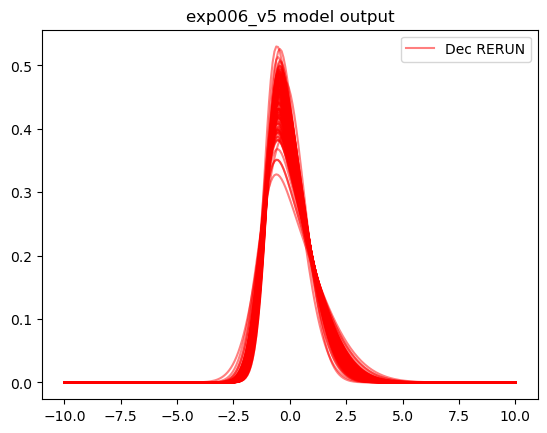

In [4]:
# open v0 model: 
path = '/Users/C830793391/Documents/Research/E3SM/saved/models/exp006_v5.pth'
model_v5 = TorchModel(config=config["arch"])
model_v5.load_state_dict(torch.load(path))
model_v5.eval()

with torch.inference_mode():
    print(device)
    exp006_v5_output = model_v5.predict(dataset=testset, batch_size=128, device=device) # The output is the batched SHASH distribution parameters
print(exp006_v5_output[:20])


x = np.linspace(-10, 10, 250)
samples = range(0, 60000, 400)

dist_V5 = Shash(exp006_v5_output)
p_V5 = dist_V5.prob(x).numpy()
print(f"shape of probability distribution V5: {p_V5.shape}")

# PLOT: 
plt.figure()

plt.plot(x, p_V5[:, samples], alpha=0.5, color='r')
plt.plot(x, p_V5[:, 5], alpha=0.5, color='r', label = 'Dec RERUN')
plt.title('exp006_v5 model output')

plt.legend()